# Interactive Attacker Activity

Using log data from a Cowrie honeypot stored in an SQLite database, we can plot the attackers on a map. 

_Harmless one-off attacks are labelled green. Suspicious attacks are marked orange. Very suspicious attacks are orange **and** with a trace line. Potential advanced persistent threats or botnets are marked red with a trace line._ 

In [21]:
import random
import warnings

import log_digester as ld

import pandas as pd
import folium
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

conn = ld.connect_db('db.sqlite')
data = pd.read_sql_query("SELECT * from attackers LIMIT 150",conn)

m = folium.Map(location=[50, -25], zoom_start=3)

for index, element in data.iterrows():
    src_ip = element['source_ip']
    if not np.isnan(element['latitude']) and not np.isnan(element['longitude']):
        lat = element['latitude'] + random.uniform(0.01,0.05)
        lon = element['longitude'] + random.uniform(0.01,0.05)
        country_name = element['country_name']
        subdivision_name = element['subdivision_name']
        city_name = element['city_name']
        attack_count = element['attack_count']
    
        if element['country_name'] is not None:
            country_name = element['country_name']
        else:
            country_name = "Unknown country"
        if element['city_name'] is not None:
            city_name = element['city_name']
        else:
            city_name = "Unknown city"
    
        if element['subdivision_name'] is not None:
            subdivision_name = element['subdivision_name']
        else:
            subdivision_name = "Unknown region"

        # Don't show attacks made from the same city as the Honeypot (aka, me logging in to test things)
        if city_name != "Toronto":
        
            attacker = [lat,lon]
            sensor = [43.6532, -79.3832]
        
            if attack_count >= 500:
                color = 'red'
                folium.PolyLine(locations=[attacker, sensor], color=color).add_to(m)
            elif 3 <= attack_count < 500:
                color = 'orange'
                folium.PolyLine(locations=[attacker, sensor], color=color).add_to(m)
            elif 0 <= attack_count < 3:
                color = 'green'
            
            popup_tag = '<i>' +city_name+', '+subdivision_name+', '+ '</i><b>'+ country_name+'<br><br>' + 'Attacks: ' + str(attack_count)
            folium.Marker(
                location=attacker, 
                popup=popup_tag,
                icon=folium.Icon(color=color, icon='cloud')
            ).add_to(m)
        
        
# Draw our honeypot last so it is drawn on top
folium.Marker(
    location=[43.6532,-79.3832],
    popup='Sensor',
    icon=folium.Icon(color='blue', icon='cloud')
).add_to(m)

m

## Attacks by IP Address

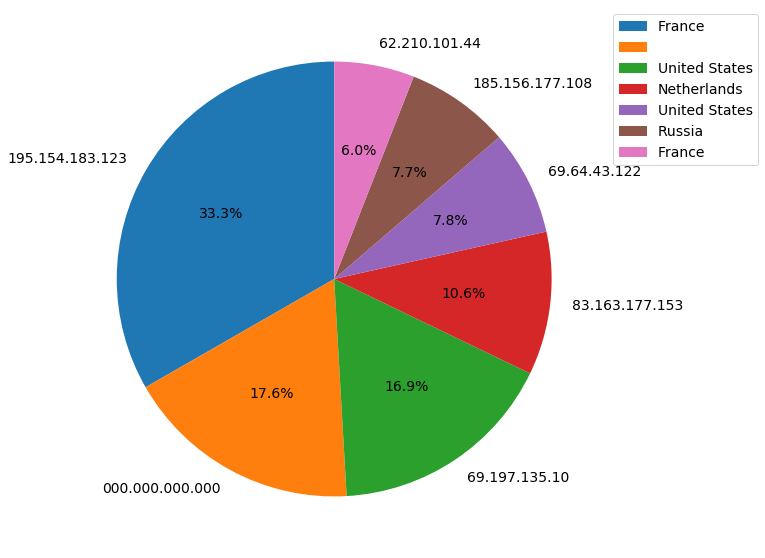

In [23]:
data = pd.read_sql_query("SELECT * from attackers", conn)
data = data.sort_values(['attack_count'],ascending=False)
data.groupby(['country_name','attack_count'])
data = data[0:7]

plt.figure(figsize=(10,10))
ax1 = plt.subplot()

data.plot(kind='pie', y = 'attack_count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=data['source_ip'], legend = False, fontsize=14)

#ax1.legend(loc=9, labels=data['country_name'])
plt.legend(bbox_to_anchor=(1,1), prop={'size': 14}, labels=data['country_name'])

ax2 = plt.subplot()
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

plt.axis('off')
plt.show()

## Attacks by Country

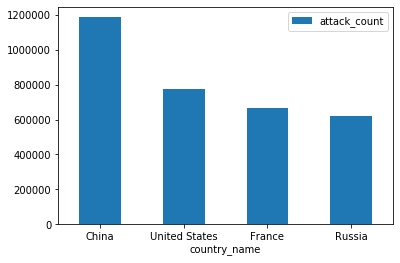

In [24]:
from IPython.display import display

data = pd.read_sql_query("SELECT * FROM countries ORDER BY attack_count DESC LIMIT 4", conn)
data = data.sort_values(by='attack_count',ascending=False)
#colors = ["#bcd4de", "#7c98b3", "#adcad6", "#848c8e", "#afbed1"]

ax = data.plot.bar(x='country_name', y='attack_count', rot=0)
plt.show()


# Attacker Hotspots (Big Players)

In [29]:
import json

import folium
import pandas as pd
import pgeocode

world_geo = json.load(open("data/world-countries.json"))       
data = pd.read_sql_query("SELECT * FROM cities ORDER BY attack_count DESC LIMIT 100" , conn)[['attack_count', 'latitude','longitude']]

# Make an empty map
m = folium.Map(location=[20,0], zoom_start=2)
 
for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']],
      #popup=data.iloc[i]['name'],
      radius=data.iloc[i]['attack_count']*5,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
m

# Attacker Hotspots (Everyone else...)

In [36]:
import json

import folium
import pandas as pd
import pgeocode

world_geo = json.load(open("data/world-countries.json"))       
data = pd.read_sql_query("SELECT * FROM cities ORDER BY attack_count LIMIT 150" , conn)[['attack_count', 'latitude','longitude']]

# Make an empty map
m = folium.Map(location=[20,0], zoom_start=2)
 
for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']],
      #popup=data.iloc[i]['name'],
      radius=data.iloc[i]['attack_count']*100000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
m